# Bag of Words with RF
* ## Dataset: ChatCoder.com (GeneralData)
* ## Paper : Detecting Predatory Behaviour in Game Chats

In [6]:
import os
import nltk
import sklearn
import pycrfsuite
import numpy as np
import sys
import resource
import string
import requests
import inspect
import pandas as pd
import seaborn as sns

#from queue import Queue as q
from bs4 import BeautifulSoup
from itertools import chain
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from multiprocessing import Pool, cpu_count, active_children, Queue, Lock
from time import sleep, time, strftime
from matplotlib import pyplot as plt

print(sklearn.__version__)
%matplotlib inline

0.17.1


In [7]:
train_path = 'GeneralData/train'
test_path = 'GeneralData/test'
train_files = []
test_files = []
chat_sents = []
lock = Lock()
stemmer = PorterStemmer()
afinn = dict(map(lambda words: (words[0], int(words[1])),
         [line.split('\t') for line in open("AFINN/AFINN-111.txt")]))

In [33]:
def correctify(data):
    payload = {'data': data}
    r = requests.get('http://127.0.0.1:1049/checkDocument', params=payload)
    
    with open("atd-log", 'a') as f:
        f.write("[%s]\n" % strftime("%c"))
        f.write("\t%s" % r.text)
        
    soup = BeautifulSoup(r.text, 'xml')
    
    if soup.error:
        all_err = soup.findAll('error')
        for err in all_err:
            s = err.description.findPrevious()
            if not err.type.string == 'grammar':
                if isinstance(err.option, type(err)):
                    if err.option.string and err.precontext.string:
                        beg = data.find(err.precontext.string + s.string) + (data.find(s.string) - data.find(err.precontext.string + s.string))
                        tmp = data[:beg-1] + ' '
                        tmp += err.option.string
                        tmp += data[beg+len(s.string):]
                        data = tmp
                        del tmp
                    elif err.option.string:
                        beg = data.find(s.string)
                        tmp = data[:beg-1] + ' '
                        tmp += err.option.string
                        tmp += data[beg+len(s.string):]
                        data = tmp
                        del tmp
    return data
#
# ----------
#
def AFINN(data):
    score = 0
    for words in nltk.word_tokenize(data):
        try:
            score = score + afinn[words.lower()]
        except KeyError:
            with open("afinn-log", 'a') as f:
                f.write("%s\n" % words)
            continue
    return score
#
# ----------
#
def data_extractor(file, mode):
    tmp=[]

    print("Extracting from: ", file)
    
    f = open(file)
    soup = BeautifulSoup(f, 'xml')

    # data extraction
    all_post = soup.findAll('POST')
    for post in all_post:
        if post.BODY.string:
            tmp.append(post.BODY.string)
            
    f.close()
    
    # spelling correction using ATD
    corrected = []
    print("Correcting: ", file)
    for s in tmp:
        corrected.append(correctify(s))
    #return corrected

    # Sentiment scoring using AFINN & saving to tsv
    print("Calculating sentiment using AFINN:", file)
    for s in corrected:
        sentiment_score = AFINN(s)
        filename = "clean-" + mode + "ing-set.tsv"
        with open(filename, 'a') as f:
            #for x, y in zip(s, sentiment_score):
            f.write("%s\t%d\n" % (s, sentiment_score))
#
# ----------
#
def get_filenames(path):
    list_of_files = []
    for subdir, dirs, files in os.walk(path):
        for file in files:
            file_path = subdir + os.path.sep + file
            list_of_files.append(file_path)
    return list_of_files
#
# ----------
#
def cb(data):
    
    if data:
        global chat_sents
        #lock.acquire()
        #[chat_sents.put(data[i]) for i in range(len(data))]
        chat_sents.extend(data)
        #lock.release()
#
# ----------
#

In [9]:
%%time
train_files = get_filenames(train_path)
test_files = get_filenames(test_path)

CPU times: user 1.74 ms, sys: 886 µs, total: 2.63 ms
Wall time: 1.8 ms


In [10]:
#%%time
#pool = Pool(processes=cpu_count()*2, maxtasksperchild=5)

for file in train_files:
    #chat_sents.put([i for i in data_extractor(file)])
    #async_result = pool.map_async(data_extractor, train_files, callback=cb)
    #pool.apply_async(data_extractor, (file,), callback=cb)
    #print("Extracting from: ", file)
    #chat_sents.extend(data_extractor(file))
    data_extractor(file, "test")
    
'''pool.close()
while len(active_children()) > 1:
    sleep(0.5)
pool.join()'''

print("Total sents: ", len(chat_sents))

Extracting from:  GeneralData/train/flxnonya.xml
Correcting:  GeneralData/train/flxnonya.xml
Calculating sentiment using AFINN: GeneralData/train/flxnonya.xml
Extracting from:  GeneralData/train/mjn_523.xml
Correcting:  GeneralData/train/mjn_523.xml
Calculating sentiment using AFINN: GeneralData/train/mjn_523.xml
Extracting from:  GeneralData/train/lee_greer74.xml
Correcting:  GeneralData/train/lee_greer74.xml
Calculating sentiment using AFINN: GeneralData/train/lee_greer74.xml
Extracting from:  GeneralData/train/fotophix.xml
Correcting:  GeneralData/train/fotophix.xml
Calculating sentiment using AFINN: GeneralData/train/fotophix.xml
Extracting from:  GeneralData/train/dble_d1.xml
Correcting:  GeneralData/train/dble_d1.xml
Calculating sentiment using AFINN: GeneralData/train/dble_d1.xml
Extracting from:  GeneralData/train/i_smoke_alotta_weed.xml
Correcting:  GeneralData/train/i_smoke_alotta_weed.xml
Calculating sentiment using AFINN: GeneralData/train/i_smoke_alotta_weed.xml
Extracting

In [11]:
train = pd.read_csv("clean-training-set.tsv", header=0, delimiter='\t')
train.shape

(25643, 2)

In [13]:
train.columns.values

array(['chat', 'sentiment'], dtype=object)

In [16]:
train["chat"].size

25643

In [18]:
chat_sents = []

In [19]:
for i in range(train["chat"].size):
    chat_sents.append(train["chat"][i])

In [20]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = "english",   \
                             max_features = 5000)

train_data_features = vectorizer.fit_transform(chat_sents)
train_data_features = train_data_features.toarray()

In [21]:
train_data_features.shape

(25643, 5000)

In [22]:
vocab = vectorizer.get_feature_names()
print(vocab)

['00', '000', '0170', '0191', '02', '03', '0382', '04', '05', '06', '07', '08', '0824', '09', '10', '100', '100l', '10p', '10pm', '10th', '11', '110', '110385953', '1112', '1116', '1130', '1144992', '118', '11th', '12', '120', '124', '125', '1252', '128', '13', '130', '14', '140', '1424', '145', '146', '15', '15024826595', '15th', '16', '16th', '17', '1700', '175', '17th', '18', '18th', '19', '190', '192', '198', '1983', '19m', '1o', '1pm', '1s', '1se', '1st', '20', '200', '2004', '2006', '2007', '20mi', '20s', '20th', '21', '210', '2101981', '210lb', '214', '215', '2195107778', '21st', '22', '22m', '22nd', '23', '230', '234', '238', '239', '23rd', '24', '248', '249', '24th', '25', '26', '27', '28', '2b', '2day', '2h', '2hr', '2moro', '2morow', '2morrow', '2nd', '2night', '2nit', '2nite', '2x', '30', '300', '30min', '30s', '310', '312', '3197', '32', '322', '324', '33', '3349', '339', '33901', '34', '3498586', '35', '36', '378', '38', '386', '39', '3am', '3rd', '40', '400', '408', '410

In [23]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)
freqbog = []
# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    freqbog.append([count, tag])

In [24]:
len(freqbog)

5000

In [25]:
freqbog = sorted(freqbog, key=lambda x:x[0], reverse=True)

In [26]:
tags = []
for i in range(len(freqbog)):
    tags.append(freqbog[i][1])

In [27]:
tags

['low',
 'like',
 'ok',
 'want',
 'just',
 'im',
 'dont',
 'lo',
 'know',
 'think',
 'lol',
 'good',
 'yea',
 'did',
 'yeah',
 'cool',
 'really',
 'got',
 'ur',
 'yes',
 'sure',
 'oh',
 'time',
 'ya',
 'wanna',
 'yah',
 'tell',
 'love',
 'ha',
 'talk',
 'come',
 'gonna',
 'ill',
 'thats',
 'mean',
 'nice',
 'right',
 'make',
 'keel',
 'say',
 'kohl',
 'long',
 'wat',
 'feel',
 'sorry',
 'hope',
 'll',
 'didnt',
 'old',
 'wow',
 'stuff',
 'kinda',
 'going',
 'hey',
 'maybe',
 'don',
 'fun',
 'way',
 'mom',
 'wont',
 'girl',
 'look',
 'guess',
 'let',
 'lot',
 'dad',
 'id',
 'work',
 'try',
 'kew',
 'said',
 'cause',
 'high',
 'pretty',
 'bad',
 'sweet',
 'bout',
 'wait',
 'big',
 'home',
 'does',
 'huh',
 'gotta',
 'phone',
 'wish',
 'friends',
 'real',
 'guy',
 'cute',
 'guys',
 'meet',
 'tomorrow',
 'chat',
 'day',
 'ink',
 'dunno',
 'live',
 'sex',
 'far',
 'number',
 'ask',
 'doing',
 'girls',
 'koo',
 'mind',
 'cut',
 '13',
 'better',
 'talking',
 'later',
 'www',
 'bet',
 'cam',
 

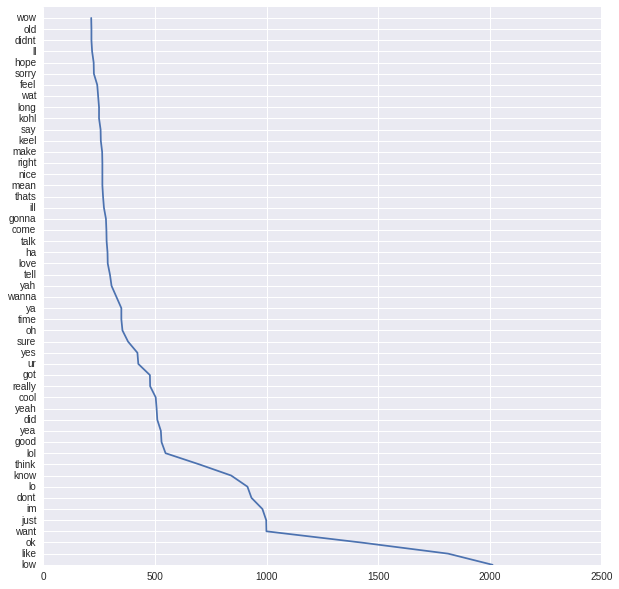

In [28]:
X = np.array([freqbog[i][0] for i in range(50)])
Y = np.array([i for i in range(50)])

_ = plt.figure(figsize=(10,10))
plt.plot(X, Y)
plt.yticks(Y, tags)
plt.show()

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 100, n_jobs=-1)
forest = forest.fit( train_data_features, train["sentiment"])

In [31]:
## Train accuracy
forest.score(train_data_features[:100], train["sentiment"][:100])

0.95999999999999996

In [34]:
for file in test_files:
    data_extractor(file, "test")

Extracting from:  GeneralData/test/shinelfmc2005.xml
Correcting:  GeneralData/test/shinelfmc2005.xml
Calculating sentiment using AFINN: GeneralData/test/shinelfmc2005.xml
Extracting from:  GeneralData/test/tunnels12000.xml
Correcting:  GeneralData/test/tunnels12000.xml
Calculating sentiment using AFINN: GeneralData/test/tunnels12000.xml
Extracting from:  GeneralData/test/sjklanke.xml
Correcting:  GeneralData/test/sjklanke.xml
Calculating sentiment using AFINN: GeneralData/test/sjklanke.xml
Extracting from:  GeneralData/test/sugardavis.xml
Correcting:  GeneralData/test/sugardavis.xml
Calculating sentiment using AFINN: GeneralData/test/sugardavis.xml
Extracting from:  GeneralData/test/sweet_jason002.xml
Correcting:  GeneralData/test/sweet_jason002.xml
Calculating sentiment using AFINN: GeneralData/test/sweet_jason002.xml
Extracting from:  GeneralData/test/thedude420xxx.xml
Correcting:  GeneralData/test/thedude420xxx.xml
Calculating sentiment using AFINN: GeneralData/test/thedude420xxx.xm

In [37]:
test = pd.read_csv("clean-testing-set.tsv", header=0, delimiter='\t')
test.shape

(25873, 2)

In [38]:
test.columns.values

array(['chat', 'sentiment'], dtype=object)

In [39]:
test_chat_sents = []
for i in range(test["chat"].size):
    test_chat_sents.append(test["chat"][i])

In [40]:
test_data_features = vectorizer.transform(test_chat_sents)
test_data_features = test_data_features.toarray()

In [41]:
result = forest.predict(test_data_features)

In [42]:
## Test accuracy
forest.score(test_data_features, test["sentiment"])

0.88899625091794532

In [44]:
print(classification_report(test["sentiment"], result))

             precision    recall  f1-score   support

        -34       0.00      0.00      0.00         1
        -17       0.00      0.00      0.00         1
        -16       0.00      0.00      0.00         2
        -14       0.00      0.00      0.00         4
        -12       0.00      0.00      0.00         1
        -11       0.00      0.00      0.00         1
        -10       0.00      0.00      0.00         6
         -9       0.00      0.00      0.00         8
         -8       0.83      0.24      0.37        21
         -7       0.00      0.00      0.00        15
         -6       1.00      0.02      0.04        50
         -5       0.69      0.38      0.49        72
         -4       0.71      0.45      0.55       193
         -3       0.80      0.72      0.76       414
         -2       0.75      0.62      0.68       670
         -1       0.60      0.43      0.50      1097
          0       0.94      0.98      0.96     16624
          1       0.85      0.90      0.87   

In [45]:
confusion_matrix(test["sentiment"], result)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Confusion matrix, without normalization
Normalized confusion matrix


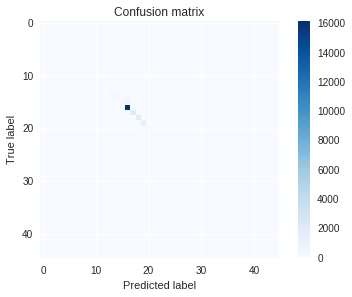

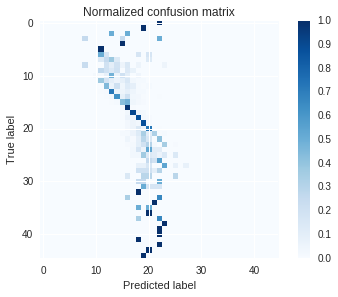

In [47]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(test["sentiment"], result)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
#print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
#print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

## ToDo:
 * Implement better spelling checker
 * Remove extra punctuations from text &,
 * Implement Stopwords removal before writing to tsv dataset
 * Implement sentiment scoring for emoticons
 * Improve spell checking
 * Improve sentiment scoring
 * Implement Flow based execution